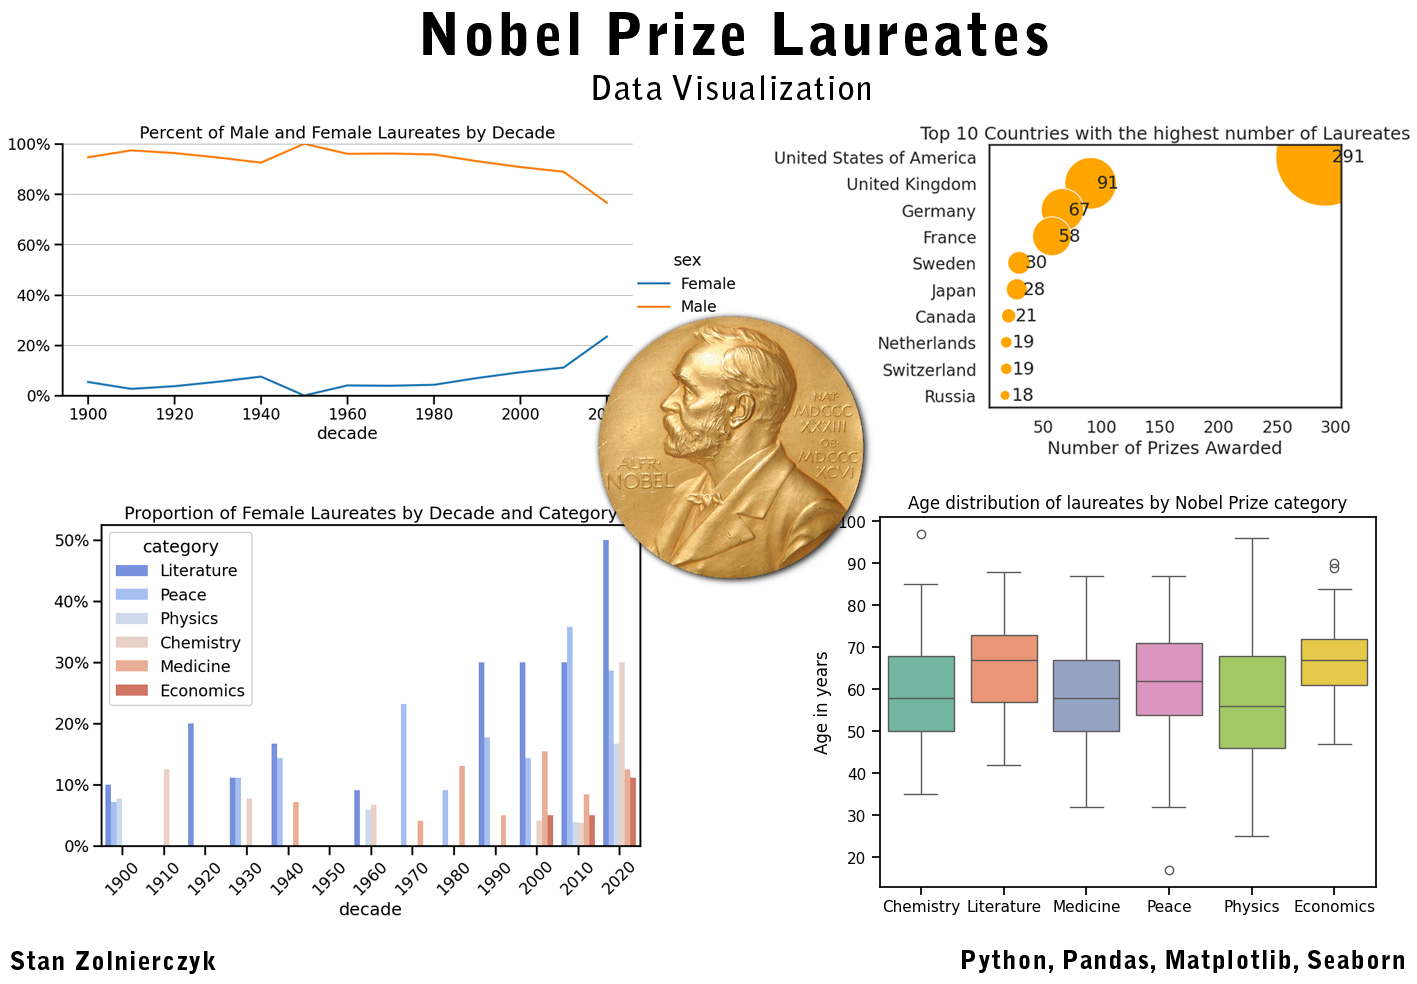

Data analysis doesn't have to be boring, one chart can quickly show many interesting insights and trends. Using the Nobel Prize winners' dataset as an example, I would like to show what interesting analyses can be performed and what conclusions can be drawn from them.
In this article I would like to focus on data visualization, showing the various possibilities offered by the Seaborn library available in Python.

In [1]:
# Load all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Load the data and convert it to dataframe, show first rows
nobel_data = pd.read_csv("nobel.csv")
nobel_data.head()

,year,category,prize,motivation,prize_share,laureate_id,laureate_type,full_name,birth_date,birth_city,birth_country,sex,organization_name,organization_city,organization_country,death_date,death_city,death_country
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,569,Individual,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,NaN,1907-09-07,Châtenay,France
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,293,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,462,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Male,NaN,NaN,NaN,1910-10-30,Heiden,Switzerland
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,463,Individual,Frédéric Passy,1822-05-20,Paris,France,Male,NaN,NaN,NaN,1912-06-12,Paris,France


# 1. What are the Top 10 most commonly awarded  Laureates' countries of birth?

In [3]:
# Group by country and count observations
nobel_data_reduced = nobel_data.groupby('birth_country').size().reset_index(name='count')

# Sort nobel_data_reduced by 'count' and pick top 10 countries
nobel_data_reduced = nobel_data_reduced.sort_values(by='count', ascending=False).head(10)
nobel_data_reduced

,birth_country,count
123,United States of America,291
122,United Kingdom,91
46,Germany,67
41,France,58
110,Sweden,30
63,Japan,28
26,Canada,21
75,Netherlands,19
111,Switzerland,19
95,Russia,18


In [4]:
# Change the font size for all plots. Smallest to largest: "paper", "notebook", "talk", "poster"
sns.set_context("talk")

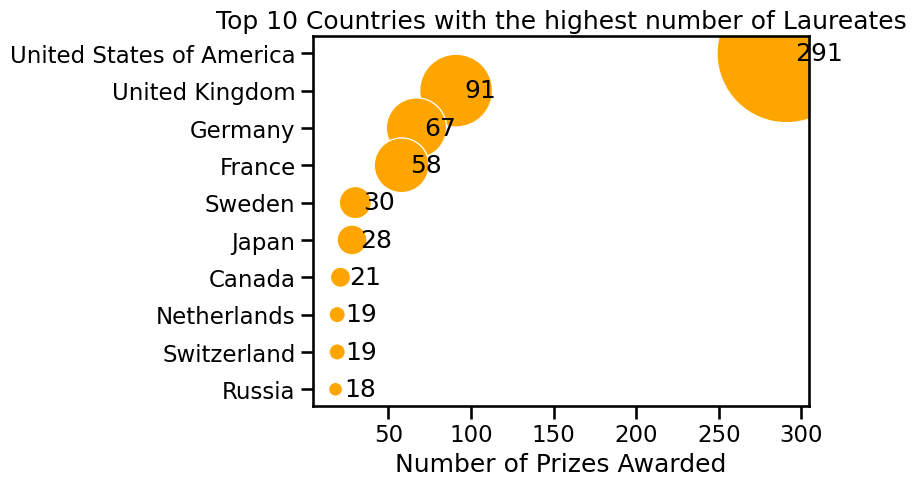

In [5]:
# Visualize results using Scatterplot
sns.scatterplot(data=nobel_data_reduced, x='count', y='birth_country', size='count',sizes=(100, 10000), color='Orange', legend=False)

# Add title and axis labels
plt.title("Top 10 Countries with the highest number of Laureates")
plt.xlabel('Number of Prizes Awarded')
plt.ylabel('')
# Add labels with values next to each dot
for i in range(len(nobel_data_reduced)):
    plt.text(x=nobel_data_reduced['count'].iloc[i] + 5,
             y=nobel_data_reduced['birth_country'].iloc[i],
             s=nobel_data_reduced['count'].iloc[i],
             ha='left', va='center')
plt.show()

The result is not a surprize. A deeper analysis would most likely show a strong correlation between the number of Nobel Prizes awarded and a country's GDP and research spending. (The number of Nobel Prizes awarded does not necessarily correlate with the total population.)

# 2. Which decade had the highest ratio of US-born Nobel Prize winners to total winners in all categories?

In [6]:
# Add a new column for decade. Use // to divide with next lower integer as a result
nobel_data['decade'] = (nobel_data['year']//10)*10
# Group by decade and cout observations
nobel_data_dedaces = nobel_data.groupby('decade').count()

# Select US-born laureates only
us_born = nobel_data[nobel_data['birth_country'] == 'United States of America']

# Count the number of US-born laureates and all laureates in each decade
us_laureates_by_decade = us_born.groupby('decade').size()
total_laureates_by_decade = nobel_data.groupby('decade').size()

# Calculate percentage of US-born laureates to all laureates
us_percent_by_decade = (us_laureates_by_decade / total_laureates_by_decade).fillna(0)*100
# convert to dataframe
us_percent_df = us_percent_by_decade.to_frame()
us_percent_df.columns = ['usa_percent']

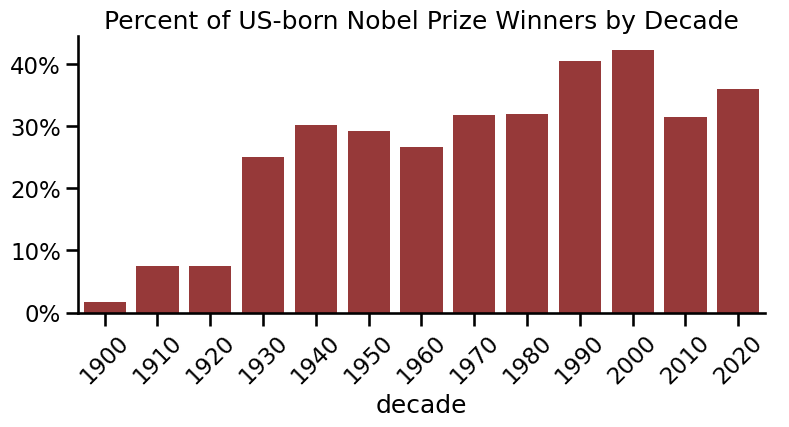

In [7]:
# Plot the data
sns.catplot(x="decade", y="usa_percent",
            data=us_percent_df,
            kind="bar",
            color='Brown',
            height=4,
            aspect=2)
plt.title('Percent of US-born Nobel Prize Winners by Decade')
# Rotate x-tick labels
plt.xticks(rotation=45)
plt.ylabel('')
# Add the % symbol to Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.show()

Conclusions: Consistent with p.1. USA was not a very rich country until the 1920s, but became one in the 1930s and began to invest heavily in sicentific research. It remains so until today, with a slight upward trend.

# 3. Which decade had the highest proportion of female laureates? Is there a trend?

In [8]:
female_winners = nobel_data[nobel_data["sex"] == 'Female']
female_winners_cat_decade = female_winners.groupby(['decade', 'category']).size().reset_index(name='fem_winners')
# Warning: results must be protected against missing results. There may be decades with no Female winners in any category, and the dataset must be filled with zeros
all_decades = sorted(nobel_data['decade'].unique())
for decade in all_decades:
  if not ((female_winners_cat_decade['decade'] == decade)).any():
      # Add a row with zeros for decade with 0 female winners
      new_row = {'decade': decade, 'category': 'Literature', 'fem_winners': 0}
      female_winners_cat_decade = pd.concat([female_winners_cat_decade, pd.DataFrame([new_row])], ignore_index=True)
all_winners_cat_decade = nobel_data.groupby(['decade', 'category']).size().reset_index(name='all_winners')
# Merge both tables to get the total number of occurrences in each decade
fem_ratio_cat_decade = pd.merge(female_winners_cat_decade, all_winners_cat_decade, on=['decade','category'])
# Add new column - Calculate percent of female winners to all winners by decade adn category
fem_ratio_cat_decade['fem_ratio'] = (fem_ratio_cat_decade['fem_winners'] / fem_ratio_cat_decade['all_winners'])*100

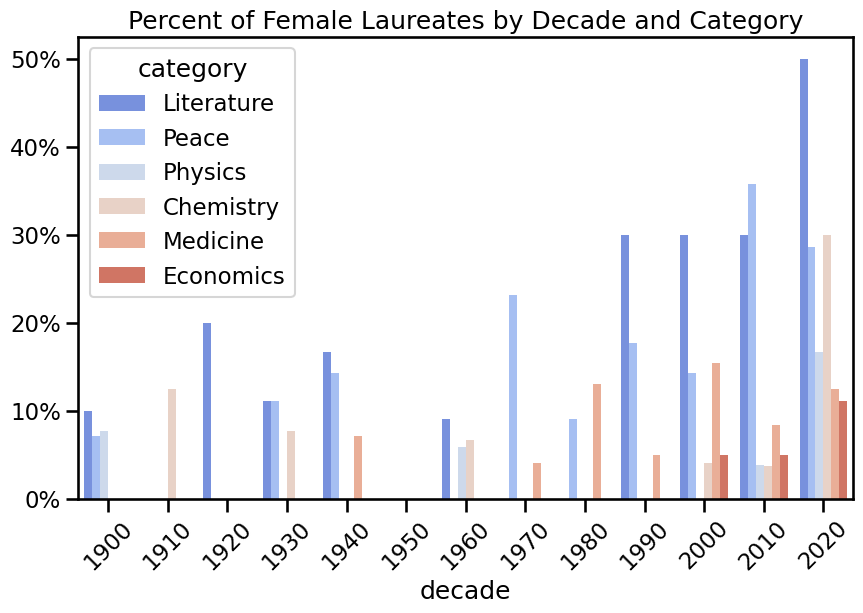

In [9]:
# set the fig size
plt.figure(figsize=(10, 6))
# Create a bar plot
sns.barplot(data=fem_ratio_cat_decade, x='decade', y='fem_ratio', hue='category', palette='coolwarm')
plt.title("Percent of Female Laureates by Decade and Category")
plt.xticks(rotation=45)
plt.ylabel('')
# Add the % symbol to Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.show()

Analysis of this graph shows that the overall proportion of female winners is increasing over the years. There is also one sad observation: in the 1950s there were no female winners in any category.

To better measure the proportion of the total number of female winners to all winners, a line graph will be used on the transformed data

In [10]:
all_winners_decade = nobel_data.groupby(['decade','sex']).size().reset_index(name='all_winners')
# Make sure that the 1950s are present in both gender groups
if not ((all_winners_decade['decade'] == 1950) & (all_winners_decade['sex'] == 'Female')).any():
    # Add new row for the 1950s female winners
    new_row = {'decade': 1950, 'sex': 'Female', 'all_winners': 0}
    all_winners_decade = pd.concat([all_winners_decade, pd.DataFrame([new_row])], ignore_index=True)
# Sort by decade and sex for chronological order
all_winners_decade = all_winners_decade.sort_values(by=['decade', 'sex']).reset_index(drop=True)

# Group by decade and sum the number of observations
total_winners_per_decade = all_winners_decade.groupby('decade')['all_winners'].transform('sum')
# Calculate percentage Obliczanie udziału procentowego dla każdej płci w ramach dekady
all_winners_decade['percent_per_decade'] = (all_winners_decade['all_winners'] / total_winners_per_decade) * 100

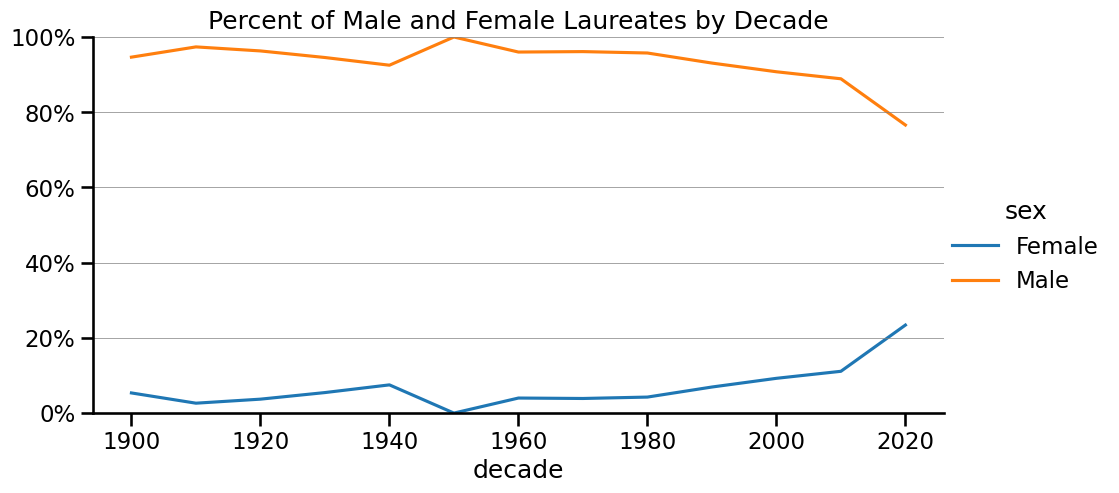

In [11]:
# Create line plot
g = sns.relplot(data=all_winners_decade, kind="line",x="decade",y="percent_per_decade",hue='sex', height=5, aspect=2)
plt.title("Percent of Male and Female Laureates by Decade")
plt.ylabel('')
# Add the % symbol to Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
# Set the range for Y axis
g.set(ylim=(0, 100))
# Add horizontal lines
for ax in g.axes.flat:
    for y_value in ax.get_yticks():
        ax.axhline(y=y_value, color='gray', linestyle='-', linewidth=0.5)
plt.show()

Conclusions: There has been a steady and consistent increase in the number of female laureates since the 1950s, with the largest increase occurring in the 2000s (although the dataset for this decade is not complete)

# 4. Correlation between Categories and age of laureates
Which category has the oldest average laureate? And which has the youngest?

In [12]:
# Convert the 'birth_date' column to a datetime format
nobel_data['birth_date'] = pd.to_datetime(nobel_data['birth_date'], errors='coerce')
# Calculate the age of the laureate upon recieving the prize
nobel_data['age'] = nobel_data['year'] - nobel_data['birth_date'].dt.year

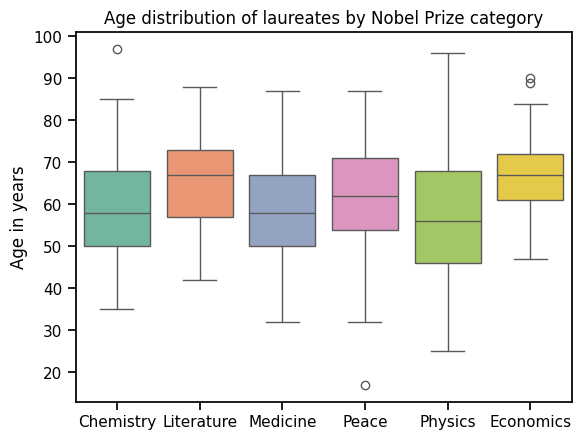

In [20]:
# Change the font size for this plot. Smallest to largest: "paper", "notebook", "talk", "poster"
sns.set_context("notebook")
# Draw a boxplot with the results
sns.boxplot(data=nobel_data, x='category', y='age', hue='category', palette='Set2')
plt.title("Age distribution of laureates by Nobel Prize category")
plt.xlabel("")
plt.ylabel("Age in years")
plt.show()

Conclusions:

1. Laureates in the field of physics are statistically the youngest. However, this field also has the widest range of results.
2. Laureatest with the highest average age are in the fields of Literature and Economics. However, in the case of economics, the awards have only been granted since the 1970s
3. The above analysis covers a period of over 120 years, so the results may not reflect the latest current trends. For more accurate results, a deeper analysis should be carried out, taking into account changes over the years.

Note: To create the above plot, standard parameters for IQRs and Whiskers for seaborn boxplot have been used (more details about boxplots are available in my other article)

# 5. Age change of Laureates over time
Are laureates getting younger or older over time?

In [14]:
#  Calculate the average age of winners in each decade for better charts readability
avg_age_by_decade = nobel_data.groupby(['decade', 'category'])['age'].mean().reset_index()
nobel_data_expanded = nobel_data.merge(avg_age_by_decade, on=['decade', 'category'], suffixes=('', '_avg'))

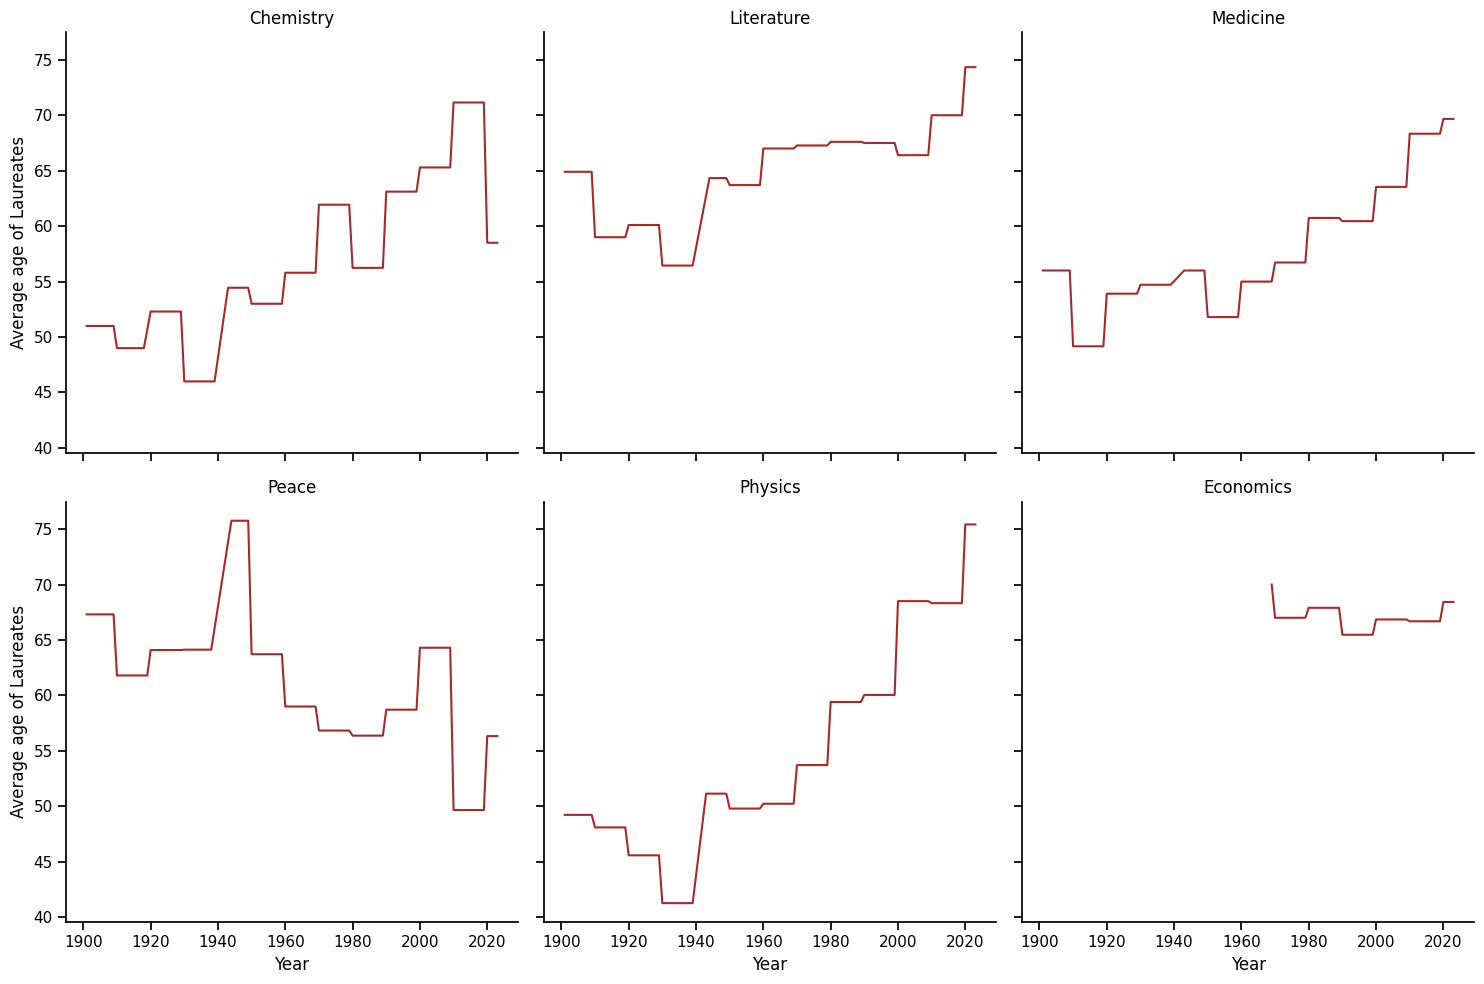

In [15]:
# Draw charts divided into categories
g = sns.relplot(data=nobel_data_expanded, x='year', y='age_avg', kind='line', color = 'Brown', col='category', errorbar=None, col_wrap=3)
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Average age of Laureates")
plt.show()

Conclusions:

1. In general, the Laureates are getting older. The most dramatic example is in the field of Physics. The only counterexample is the Nobel Peace Prize. For economics, values ​​are quite constant.

2. The above results may result from the fact that in some fields (e.g. Physics) due to the very large number of important discoveries, scientists are often awarded the prize  several (or more) years after the publication of their works.


# 6. Bonus Section: What is the average lifespan of laureates by category?
Does the profession of a scientist guarantee a long life? :-)


In [16]:
# Convert the'death_date' column to a datetime format
nobel_data_expanded['death_date'] = pd.to_datetime(nobel_data['death_date'], errors='coerce')

# Calculate the age at death, ommit for the laureates that are still alive
nobel_data_expanded['age_at_death'] = nobel_data_expanded.apply(
    lambda row: (row['death_date'].year - row['birth_date'].year
                 - ((row['death_date'].month, row['death_date'].day) <
                    (row['birth_date'].month, row['birth_date'].day)))
    if pd.notnull(row['death_date']) and pd.notnull(row['birth_date']) else None,
    axis=1
)

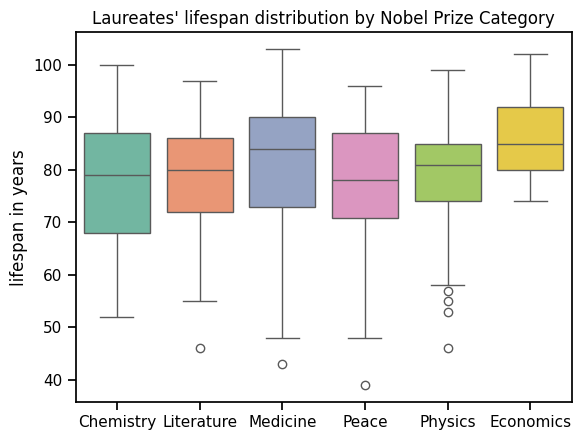

In [19]:
sns.boxplot(data=nobel_data_expanded, x='category', y='age_at_death', hue='category', palette='Set2')
plt.title("Laureates' lifespan distribution by Nobel Prize Category")
plt.xlabel("")
plt.ylabel("lifespan in years")
plt.show()

Based on this particular data, the the answer is: average life expectancy of laureates is around 80 years, with the highest in the field of Economics.
However, the analysis did not answer the question of whether being a Nobel Prize-winning scientist makes you live longer than the average for the general population. To get a satisfactory answer to this question, the results would have to be compared with data for the general population, divided by year and country of birth.

# Summary
Tools currently available through standard Python libraries (Pandas, Numpy, Matplotlib) allow for fast and efficient data analysis, and the Seaborn library enables rapid and diverse visualizations with flexible customization options.  Data analysis results become accessible and understandable for practically everyone.
Flexibility and customizable styles make data analysis visually appealing and deliver the necessary information and conclusions in the most convenient way.